# 194.049 Energy-efficient Distributed Systems
## Assignment Part 2: Simulation infrastructure and preliminary implementation
### Gent Rexha (11832486), Princ Mullatahiri (11846033), Ilir Osmanaj (11770999)
#### 29.05.2019

In [1]:
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import pandas as pd
from pathlib import Path
from keras import Sequential
from keras.layers import LSTM, Dense
from matplotlib import pyplot
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
from plotnine import *

Using TensorFlow backend.


## Preprocessment

In [2]:
import platform
if platform.system() == 'Darwin':
    data_path = Path('../data')
else:
    data_path = Path('C:/Projects/University/Semester 2 Projects/Energy-efficient Distributed Systems/energy_efficient_ds/Assignment P3/data')

### Data Preparation

In [134]:
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

df = pd.read_csv(data_path / 'web_traffic_wikipedia_tiny.csv', date_parser=parse)  
df = df.transpose()
df = df.rename(columns=df.iloc[0]).drop(df.index[0])
df.reset_index(level=0, inplace=True)
df = df.rename(index=str, columns={"index": "date"})
df['date'] =  pd.to_datetime(df['date'],
                              format='%Y %m %d')
# Select only 2 columns and rename them for quickstart example
df = df[['date','Google_zh.wikipedia.org_all-access_all-agents']]
df = df.rename(index=str, columns={"Google_zh.wikipedia.org_all-access_all-agents": "y"})
df = df.set_index('date')
df.head()

,y
date,
2015-07-01,1157
2015-07-02,1982
2015-07-03,2058
2015-07-04,1623
2015-07-05,1755


In [135]:
import random
from copy import deepcopy

# Select only temp and first year for forecast
df_pred = deepcopy(df)
print(df_pred.head())

def create_gap(df, number_of_gaps: int = 1, seed: int = None):
    """Creates a artificial made gap in the first column of the dataset with a size from 50-100.
    
    Args:
        df (pd.Dataframe): dataframe where the gap should be created
    
    Output:
        dataset (pd.Dataframe): dataframe with random gap
    """
    dataset = deepcopy(df)
    already_created_gap = set()
    gap_ranges= []
    
    if seed:
        random.seed(seed)
    
    for i in range(0, number_of_gaps):
        gap_is_valid = False
        
        # try to re-generate the gap so that its not in the same range
        while not gap_is_valid:
            gap_start = random.randint(50, len(df.index))
            gap_size = random.randint(50,100)
            # all indexes generated should not be in the greated gap 
            # we make sure to not overwrite the same gap twice
            gap_is_valid = all([i not in already_created_gap] for i in range(gap_start, gap_size))
            
            if gap_is_valid:
                dataset.iloc[gap_start : gap_start + gap_size] = np.nan
                # store the created gap ranges
                gap_ranges.append((gap_start, gap_start + gap_size))

    return dataset, gap_ranges


df_gap, gap_ranges = create_gap(df_pred, number_of_gaps=3, seed=10)
print(gap_ranges)
print(df_gap.iloc[630:700])

               y
date            
2015-07-01  1157
2015-07-02  1982
2015-07-03  2058
2015-07-04  1623
2015-07-05  1755
[(635, 687), (489, 569), (641, 691)]
               y
date            
2017-03-22  4217
2017-03-23  5074
2017-03-24  4986
2017-03-25  5246
2017-03-26  5084
2017-03-27   NaN
2017-03-28   NaN
2017-03-29   NaN
2017-03-30   NaN
2017-03-31   NaN
2017-04-01   NaN
2017-04-02   NaN
2017-04-03   NaN
2017-04-04   NaN
2017-04-05   NaN
2017-04-06   NaN
2017-04-07   NaN
2017-04-08   NaN
2017-04-09   NaN
2017-04-10   NaN
2017-04-11   NaN
2017-04-12   NaN
2017-04-13   NaN
2017-04-14   NaN
2017-04-15   NaN
2017-04-16   NaN
2017-04-17   NaN
2017-04-18   NaN
2017-04-19   NaN
2017-04-20   NaN
...          ...
2017-05-01   NaN
2017-05-02   NaN
2017-05-03   NaN
2017-05-04   NaN
2017-05-05   NaN
2017-05-06   NaN
2017-05-07   NaN
2017-05-08   NaN
2017-05-09   NaN
2017-05-10   NaN
2017-05-11   NaN
2017-05-12   NaN
2017-05-13   NaN
2017-05-14   NaN
2017-05-15   NaN
2017-05-16   NaN
2017-05-17 

### Visualizations

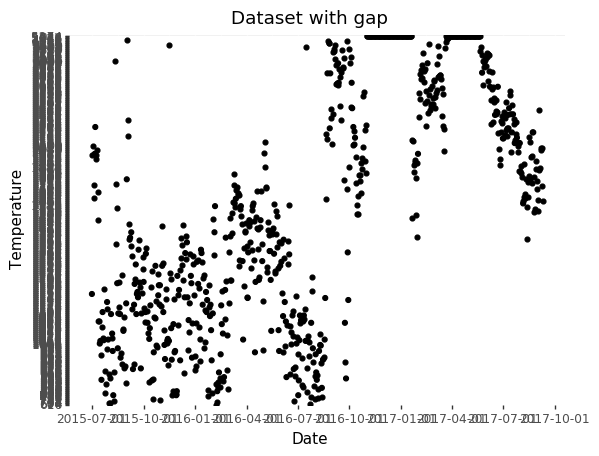

<ggplot: (-9223372029267204562)>


In [137]:
g1 = ggplot(df_gap, 
            aes('df_gap.index', 'y')) + \
            geom_point() + labs(x='Date', y='Temperature', title='Dataset with gap')
print(g1)

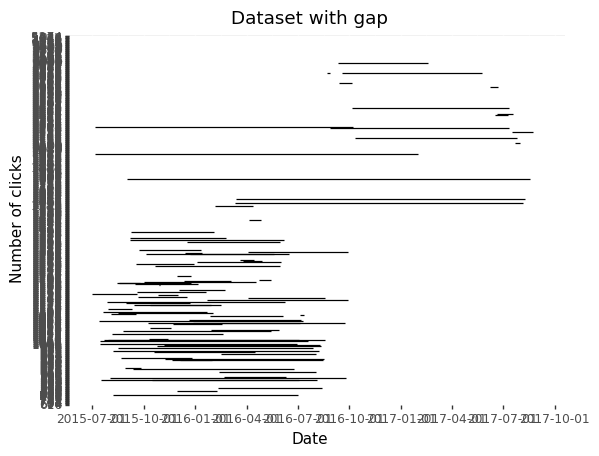

<ggplot: (7587068445)>


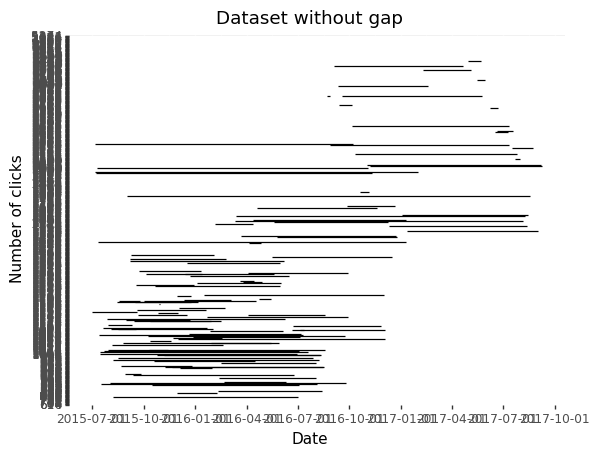

<ggplot: (-9223372029259574910)>
[(635, 687), (489, 569), (641, 691)]


/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


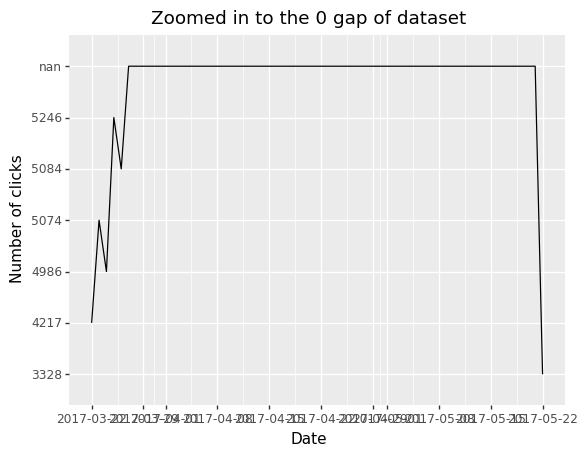

<ggplot: (7587050851)>


/anaconda3/lib/python3.7/site-packages/plotnine/geoms/geom_path.py:80: UserWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
  warn("geom_path: Each group consist of only one "


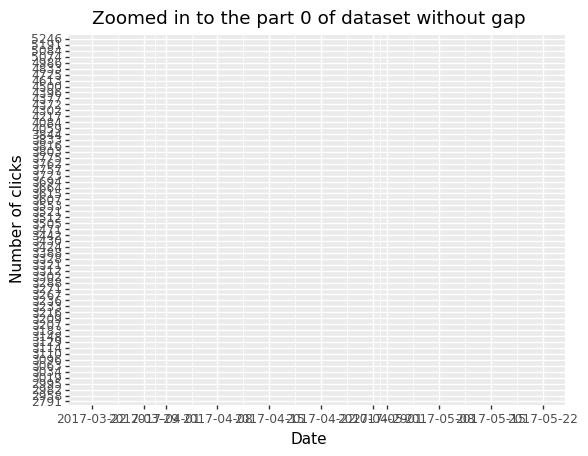

<ggplot: (-9223372029269690382)>


/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


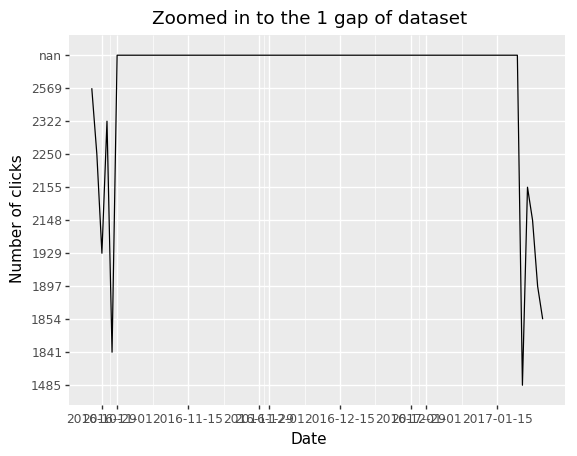

<ggplot: (7588143094)>


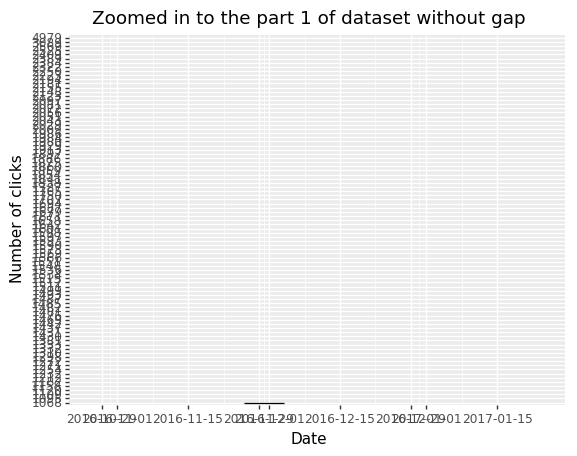

<ggplot: (7587050844)>


/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


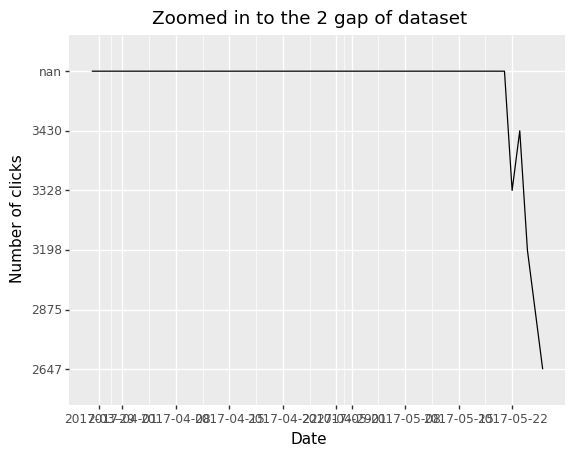

<ggplot: (-9223372029258711264)>


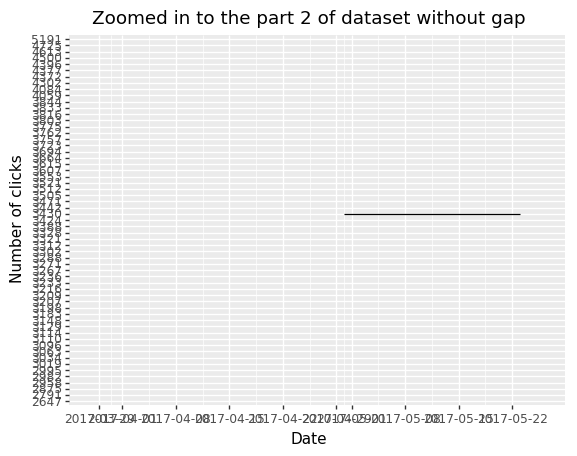

<ggplot: (7587241266)>


In [139]:
# df_gap
g1 = ggplot(df_gap, 
            aes('df_gap.index', 'y')) + \
            geom_line() + labs(x='Date', y='Number of clicks', title='Dataset with gap')
gg
print(g1)

# df_pred
g2 = ggplot(df_pred, 
            aes('df_pred.index', 'y')) + \
            geom_line() + labs(x='Date', y='Number of clicks', title='Dataset without gap')
print(g2)

one_month_interval = 5
print(gap_ranges)
# Zoomed in version of df_gap
for i, gap_range in enumerate(gap_ranges):
    dataset = df_gap.iloc[gap_range[0] - one_month_interval : gap_range[1] + one_month_interval]
    
    g3 = ggplot(dataset,
                aes('dataset.index', 'y', group=1)) + \
                geom_line() + labs(x='Date', y='Number of clicks', title='Zoomed in to the {} gap of dataset'.format(i))
    print(g3)

    # Zoomed in version of df_pred
    dataset = df_pred.iloc[gap_range[0]-one_month_interval : gap_range[1] + one_month_interval]
    g4 = ggplot(dataset, 
                aes('dataset.index', 'y')) + \
                geom_line() + labs(x='Date', y='Number of clicks', title='Zoomed in to the part {} of dataset without gap'.format(i))
    print(g4)

In [91]:
def perfrom_scaling(values):
    scaler = MinMaxScaler(feature_range=(0, 1))
    return scaler.fit_transform(values)

### Transforming Time Series Data into a Supervised Machine Learning Problem

In [92]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """Frame a time series as a supervised learning dataset.
    
    Args:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        pd.Dataframe: The return value. True for success, False otherwise.
    
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = deepcopy(pd.DataFrame(data))
    cols = list()
    names = list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    return agg

In [94]:
# frame as supervised learning
reframed = series_to_supervised(values, 1, 1)[1:]
reframed_original = series_to_supervised(values_original, 1, 1)[1:]
print(reframed.head())

    var1(t-1) var2(t-1)     var1(t) var2(t)
1  2015-07-01      1157  2015-07-02    1982
2  2015-07-02      1982  2015-07-03    2058
3  2015-07-03      2058  2015-07-04    1623
4  2015-07-04      1623  2015-07-05    1755
5  2015-07-05      1755  2015-07-06    1985


In [95]:
values = reframed.values
values_original = reframed_original.values

# concatinate all non-gap data in one variable
all_merged = []
for gap_range in gap_ranges:
    all_merged.append(values[1:gap_range[0] + 1, :])
    all_merged.append(values[gap_range[1]:, :])
    
all_data = np.concatenate(all_merged)

# use most of the data as train, and from 100 to 200 for testing
train = all_data[list(range(0, 100)) + list(range(200, all_data.shape[0] - 1)),:][:2500]
# train = all_data[list(range(0, 100)),:]
validation = all_data[list(range(100, 200)),:]

# test contains only data from the gap (but we use the orignal dataset - since they are not none)
original_gaps_merged = [] 
for gap_range in gap_ranges:
    original_gaps_merged.append(values_original[gap_range[0]: gap_range[1], :])
    
test = np.concatenate(original_gaps_merged)

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
validation_X, validation_y = validation[:, :-1], validation[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
validation_X = validation_X.reshape((validation_X.shape[0], 1, validation_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, validation_X.shape, validation_y.shape)

(2077, 1, 3) (2077,) (100, 1, 3) (100,)


In [96]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=10, batch_size=1, 
                    validation_data=(validation_X, validation_y), verbose=2, shuffle=False)

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 2077 samples, validate on 100 samples
Epoch 1/10


ValueError: could not convert string to float: '2015-07-02'

In [33]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Gap RMSE: %.3f' % rmse)

Gap RMSE: 1.417


### Visualizing predicted vs actual values

[(7608, 7685), (3644, 3695), (7554, 7625)]
77


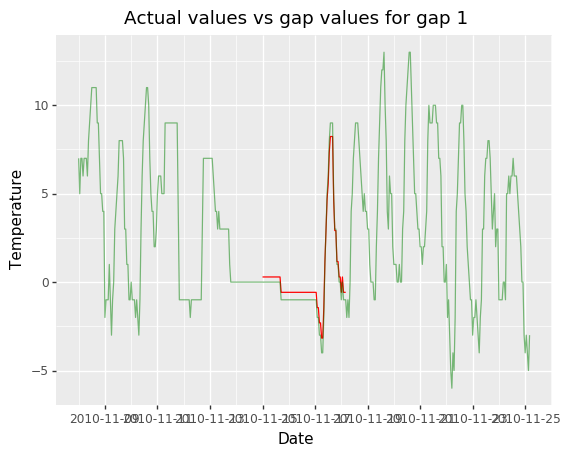

<ggplot: (126930112376)>
51


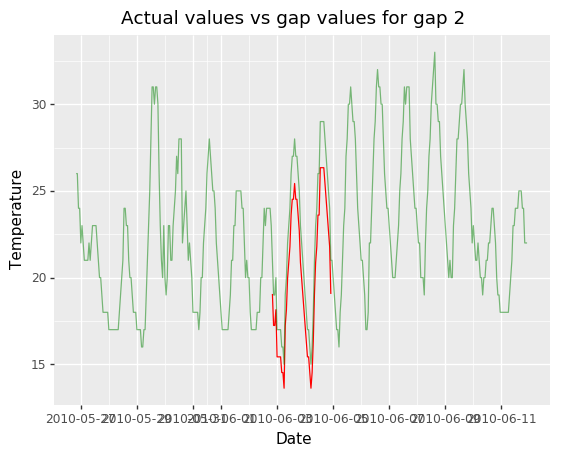

<ggplot: (126931167615)>
71


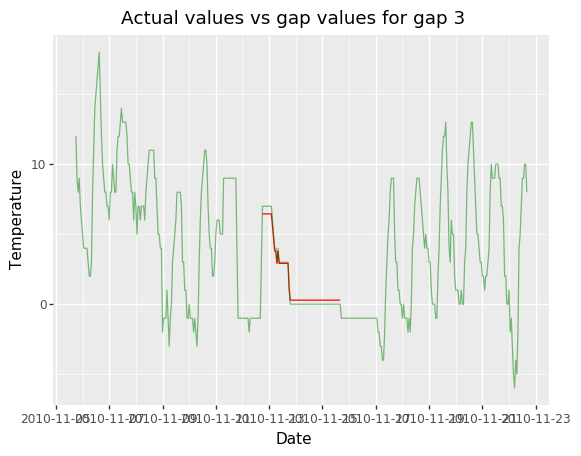

<ggplot: (-9223371909923613752)>


In [34]:
# Insert predicted values into df_gap
print(gap_ranges)
for i, gap_range in enumerate(gap_ranges):
    # some magic to know where to fetch the yhat for each gap_range
    start_in_yhat = 0 if i == 0 else sum(c[1] - c[0] for c in gap_ranges[:i])
    
    print(len(inv_yhat[start_in_yhat: start_in_yhat + (gap_range[1] - gap_range[0])]))
    df_gap.iloc[gap_range[0] : gap_range[1], 0] = inv_yhat[start_in_yhat: start_in_yhat + (gap_range[1] - gap_range[0])]
    
    df1 = df_gap.iloc[gap_range[0] : gap_range[1]]
    df2 = df_pred.iloc[gap_range[0] - one_week_interval : gap_range[1] + one_week_interval]

    g1 = ggplot() + \
         geom_line(df1, aes('df1.index', 'temp'), color='red') + \
         geom_line(df2, aes('df2.index', 'temp'), color='green', alpha=0.5) + \
        labs(x='Date', y='Temperature', title='Actual values vs gap values for gap {}'.format(i + 1))
    print(g1)